### Let's plot our most recent Torque log in python

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import osmapping
import glob
%matplotlib inline

Import the file into pandas, and drop all rows without a GPS fix

In [2]:
dname = '/Users/astyler/projects/torquedata/'
trips = []
fnames = glob.glob(dname+'*.csv')
for fname in fnames:
    trip = pd.read_csv(fname, na_values=['-'],encoding ='U8',index_col=False, header=False, names=['GPSTime','Time','Longitude','Latitude','GPSSpeed','GPSError','Altitude','Bearing','Gx','Gy','Gz','G','Az','Ay','Ax','A','Power','Accuracy','Satellites','GPSAltitude','GPSBearing','Lat2','Lon2','OBDSpeed','GPSSpeedkmhr'])
    trip = trip.dropna(subset = ['Longitude','Latitude'])
    trips.append(trip)
    
fnames

['/Users/astyler/projects/torquedata/trackLog-2015-Jun-23_20-04-47.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-23_20-16-16.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-24_11-34-51.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-24_17-01-36.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-25_11-29-06.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-25_18-14-03.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-26_10-02-30.csv',
 '/Users/astyler/projects/torquedata/trackLog-2015-Jun-26_17-06-10.csv']

Find the Lat/Lon bounding box and create a new map from the osmapping library

In [28]:
buffr = 0.01
mins=[(min(trip.Longitude) -buffr,min(trip.Latitude)-buffr) for trip in trips]
maxs=[(max(trip.Longitude) + buffr,max(trip.Latitude)+buffr) for trip in trips]

ll = map(min,zip(*mins))
ur = map(max,zip(*maxs))
print ll
print ur
mymap = osmapping.MLMap(ll,ur)

[-71.115385145812226, 42.353026112822064]
[-71.081204217085244, 42.37951189666768]


In [29]:
for trip in trips:
    trip['x'], trip['y'] = mymap.convert_coordinates(trip[['Longitude','Latitude']].values).T

Import the shapefiles from [Mapzen](https://mapzen.com/data/metro-extracts) for Boston

In [30]:
reload(osmapping)
mymap.load_shape_file('./shapefiles/boston/line.shp')
mymap.load_shape_file('./shapefiles/boston/polygon.shp')


In [31]:
mymap.shapes.shape

(9743, 59)

In [32]:
coords = [(79,80),(15,24)]

print zip(*coords)
print zip(*[(1,1),(2,2)])
#print mymap.basemap([79,15],[80,24])
print mymap.basemap(79,80)
print mymap.basemap(15,24)
print zip(*mymap.basemap(*zip(*coords)))


[(79, 15), (80, 24)]
[(1, 2), (1, 2)]
(16710882.384775383, 10311515.59444322)
(9586434.974005872, -2449020.159358382)
[(16710882.384775383, 10311515.59444322), (9586434.974005872, -2449020.159358382)]


Select most road-types and some parks for plotting

In [45]:
mymap.clear_selected_shapes()

road = {'edgecolor':'white','lw':3, 'facecolor':'none','zorder':6};

mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#BBDDBB',edgecolor='none',zorder=4)
mymap.select_shape('waterway','riverbank',facecolor='#0044CC', edgecolor='none', zorder=5)

mymap.select_shape('natural','water',facecolor='#CCCCEE', edgecolor='none', zorder=5)

In [46]:
bselect = lambda x: x['building'] in ['yes', 'apartments', 'commercial', 'house', 'residential', 'university', 'church', 'garage'] 

bldg = {'facecolor':'none', 'edgecolor':'#dedede', 'hatch':'////','zorder':7}
mymap.select_shapes(bselect, **bldg)

Plot the basemap and then overlay the trip trace

In [47]:
for trip in trips:
    trip.loc[trip.Satellites < 5,'Satellites'] = None
    trip.loc[trip.Accuracy > 20,'Accuracy'] = None
    trip.dropna(subset=['Accuracy'], inplace=True)

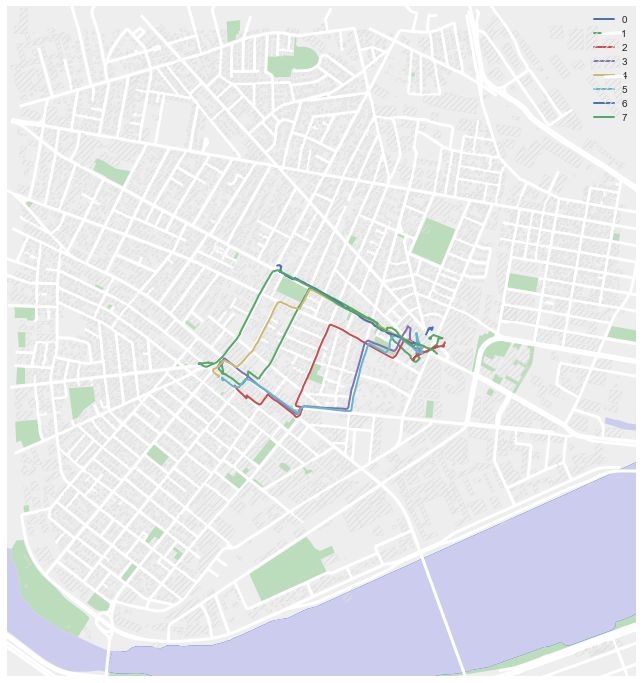

In [48]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (idx,trip) in enumerate(trips):
    ax.plot(trip.x, trip.y, lw=2, alpha=1,zorder=99, label=str(idx))

plt.legend()